In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 52kB/s 


In [ ]:
import os
import scipy
import sklearn
import matplotlib
# from tqdm import tqdm, trange
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
#dataset
from sklearn import datasets
#fold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
#
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# this is our global size of label text
# on the plots
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
SEED =13
from IPython.display import display, HTML, Image
PATH = '/content/drive/My Drive/Encode_Challenge/data/project_1'

## Categorical Features Encoding Challenge from Kaggle

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


The dataset consists of all kinds of categorical variables:
- Nominal
- Ordinal
- Cyclical
- Binary

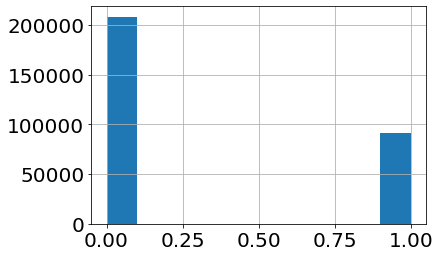

In [ ]:
df.target.hist()

### label encode by hands

In [ ]:
mapping = {
"Freezing": 0,
"Warm": 1,
"Cold": 2,
"Boiling Hot": 3,
"Hot": 4,
"Lava Hot": 5
}

df.loc[:, 'ord_2'] = df.ord_2.map(mapping)
df.ord_2.value_counts()

0    99816
5    63908
3    60627
2    33768
4    22227
1    19654
Name: ord_2, dtype: int64

### lbEncode by sklearn

In [ ]:
lb = sklearn.preprocessing.LabelEncoder()
df.loc[:, 'ord_2'] = lb.fit_transform(df.loc[:, 'ord_2'])
df.ord_2.value_counts()

2    99816
4    63908
0    60627
1    33768
3    22227
5    19654
Name: ord_2, dtype: int64

In [ ]:
def lbe(train : pd.DataFrame,  test : pd.DataFrame) -> pd.DataFrame:
  """
  label encode for all data, and we need check NAN
  train / test : DFrame 

  Merge data, check nan in data after label encode

  return train, test
  """
  test_col = test.columns
  test.loc[:, 'target'] = -1
  col_encode = [c for c in train.columns if c not in ["id", "target"]]
  
  if all(train.columns == test.columns) is False:
    raise Exception('train and test columns is different')
  #merge data
  data = pd.concat([train, test]).reset_index(drop=True)
  #check NAN
  for col in col_encode:
    lb = sklearn.preprocessing.LabelEncoder()
    temp_col = data[col].fillna('NONE').astype(str).values
    data.loc[:, col] = lb.fit_transform(temp_col)
  
  train = data[data.target != -1].reset_index(drop=True)
  test = data[data.target == -1].reset_index(drop=True)
  return train, test[test_col]


# train = pd.read_csv(os.path.join(PATH, 'train.csv'))
# test = pd.read_csv(os.path.join(PATH, 'test.csv'))
# tr, te = lbe(train, test)

### csr_matrix

In [ ]:
a = np.array([
          [0,0,1],
          [1,0,0],
          [1,0,1]
])
print(a.nbytes) # 3*3*8

a_sparse = scipy.sparse.csr_matrix(a)
print(a_sparse.data.nbytes)

72
32


In [ ]:
a = np.random.randint(1000, size = 100000)
a = a.reshape(-1, 1)
oh = sklearn.preprocessing.OneHotEncoder(sparse=False)
a_nosparse = oh.fit_transform(a)
oh = sklearn.preprocessing.OneHotEncoder(sparse=True)
a_sparse = oh.fit_transform(a)
print(
    a_nosparse.nbytes,
    a_sparse.data.nbytes + a_sparse.indptr.nbytes + a_sparse.indices.nbytes
)

800000000 1600004


### very simple example features

In [ ]:
df.ord_2.value_counts()

Freezing       99816
Lava Hot       63908
Boiling Hot    60627
Cold           33768
Hot            22227
Warm           19654
Name: ord_2, dtype: int64

In [ ]:
df.groupby(["ord_2"])["id"].count()

ord_2
Boiling Hot    60627
Cold           33768
Freezing       99816
Hot            22227
Lava Hot       63908
Warm           19654
Name: id, dtype: int64

If we simply replace the ord_2 column with its counter values, we convert it to a feature that is now numeric. We can create a new column or replace it with column using pandas transform function along with groupby.

In [ ]:
df.groupby(["ord_2"])["id"].transform('count')

0         33768
1         22227
2         63908
3         60627
4         99816
          ...  
299995    99816
299996    99816
299997    60627
299998    60627
299999    99816
Name: id, Length: 300000, dtype: int64

https://stackoverflow.com/questions/27517425/apply-vs-transform-on-a-group-object

Two major differences between apply and transform
There are two major differences between the transform and apply groupby methods.

Input:
- apply implicitly passes all the columns for each group as a DataFrame to the custom function.
- while transform passes each column for each group individually as a Series to the custom function.

Output:

- The custom function passed to apply can return a scalar, or a Series or DataFrame (or numpy array or even list).
- The custom function passed to transform must return a sequence (a one dimensional Series, array or list) the same length as the group.

So, transform works on just one Series at a time and apply works on the entire DataFrame at once.



In [ ]:
df.groupby(["ord_1", "ord_2"])["id"].count().reset_index(name="count")

,ord_1,ord_2,count
0,Contributor,Boiling Hot,8692
1,Contributor,Cold,4842
2,Contributor,Freezing,14284
3,Contributor,Hot,3122
4,Contributor,Lava Hot,9074
5,Contributor,Warm,2857
6,Expert,Boiling Hot,4980
7,Expert,Cold,2850
8,Expert,Freezing,8432
9,Expert,Hot,1887


Another trick is to create new functions from these categorical variables. You can create new categorical functions from existing functions and this can be done in an easy way.

In [ ]:
df["new_feature"] = (df.ord_1.astype(str)+ "_"+ df.ord_2.astype(str))
df.new_feature

0                Grandmaster_Cold
1                 Grandmaster_Hot
2                 Expert_Lava Hot
3         Grandmaster_Boiling Hot
4            Grandmaster_Freezing
                   ...           
299995       Contributor_Freezing
299996            Novice_Freezing
299997         Novice_Boiling Hot
299998         Master_Boiling Hot
299999       Contributor_Freezing
Name: new_feature, Length: 300000, dtype: object

### StratifiedKFold

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=13)
for fold, (t_idx, v_idx) in enumerate(kf.split(X=df, y= df.target.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'kfold'] = fold
df.to_csv(os.path.join(PATH, 'train_folds.csv'), index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


240000 60000
240000 60000
240000 60000
240000 60000
240000 60000


In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
df.kfold.value_counts()

4    60000
3    60000
2    60000
1    60000
0    60000
Name: kfold, dtype: int64

In [ ]:
for i in range(4):
  display(df[df.kfold == i].target.value_counts())

0    41648
1    18352
Name: target, dtype: int64

0    41647
1    18353
Name: target, dtype: int64

0    41647
1    18353
Name: target, dtype: int64

0    41647
1    18353
Name: target, dtype: int64

#### Feature hashing 

In [ ]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10)
D = [{'dog': 1, 'cat':2, 'elephant':4},{'dog': 1,'dog': 2, 'run': 5}]
f = h.transform(D)
f.toarray()

array([[ 0.,  0., -4., -1.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0., -2., -5.,  0.,  0.,  0.,  0.,  0.]])

#### Encoding cyclic features

http://www.math.ust.hk/~machiang/1013/Notes/tri_func.html

day	 and month

In [ ]:
Image(url='http://www.math.ust.hk/~machiang/1013/Notes/sine_2.gif')

In [ ]:
Image(url='http://www.math.ust.hk/~machiang/1013/Notes/cosine_2.gif')

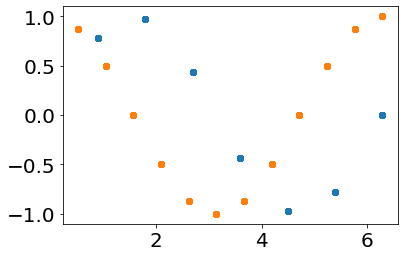

In [ ]:
#norm (2 *np.pi * val) / max(val)
sin_day = np.sin((2 *np.pi * df.day) / max(df.day))
cos_month = np.cos((2 *np.pi * df.month) / max(df.month))

plt.scatter(
    x = (2 *np.pi * df.day) / max(df.day),
    y = sin_day
    
)
plt.scatter(
    x = (2 *np.pi * df.month) / max(df.month),
    y = cos_month
    
)

In [ ]:
def cyclic_feature(data: pd.DataFrame)->None:
  """
  encode cycler features
  day   - sin
  month - cos  
  """
  col = ['day', 'month']  
  for c in col:
    if c == 'day':
      data[f'sin_{c}'] = np.sin((2 *np.pi * data[c]) / (data[c].max()))
    else:
      data[f'cos_{c}'] = np.cos((2 *np.pi * data[c]) / (data[c].max()))
  data.drop(col, axis = 1, inplace = True)

####  Target encoding

In this method, we replace the categorical variable with only one new numeric variable and replace each category with a categorical variable with the corresponding goal probability (if categorical) or the mean of the goal (if numeric).

The main disadvantages of this method are its dependence on the target distribution and its lower predictability compared to the binary coding method.

THE KEY POINT IS THAT THE TARGET IS NOT IN THE TEST AND SHOULD BE APPLIED TO THE TEST AFTER CODING

In [ ]:
df.nom_3

0            Finland
1             Russia
2             Russia
3             Canada
4             Canada
             ...    
299995         India
299996        Russia
299997        Russia
299998    Costa Rica
299999        Russia
Name: nom_3, Length: 300000, dtype: object

In [ ]:
#df.groupby('nom_3')['target'].agg('sum') / df.groupby('nom_3')['target'].agg('count') одно и тоже просто наглядней
target = dict(df.groupby('nom_3')['target'].agg('mean'))
target

{'Canada': 0.33979299713719446,
 'China': 0.3117235687603162,
 'Costa Rica': 0.3146882294098033,
 'Finland': 0.24281305830761735,
 'India': 0.36131143162393164,
 'Russia': 0.28995381861693187}

In [ ]:
df.nom_3.map(target).value_counts()

0.289954    101123
0.339793     49951
0.311724     46044
0.242813     36942
0.314688     35988
0.361311     29952
Name: nom_3, dtype: int64

#### k-fold target encoding

To reduce overfitting, k-fold target coding can be applied. In this method, we divide the dataset into k folds, here we consider 5 folds.

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,kfold
0,286118,0,0,0,T,Y,Green,Trapezoid,Snake,India,Oboe,60a44c8f4,c36cea1f7,9d6653dde,3032ce76e,b951652da,2,Novice,Lava Hot,d,R,Qo,3,1,0,0
1,257514,0,0,0,T,Y,Blue,Trapezoid,Lion,Finland,Bassoon,bd40c81f3,edb3cf6c8,59de9c26a,feb50e76d,5ecdf8481,1,Grandmaster,Cold,k,L,CU,7,8,0,0
2,35412,0,1,0,T,Y,Green,Trapezoid,Snake,Finland,Piano,493de6347,ec97e8751,e1ea45053,ae06e29df,581de94cb,1,Novice,Cold,f,I,KR,3,2,0,0
3,251790,0,1,0,T,N,Blue,Circle,Dog,India,Oboe,a3f640358,803f6cece,76f770ea1,6f85744aa,6dfac0823,1,Novice,Boiling Hot,i,P,Uk,3,3,0,0
4,28874,0,0,1,T,Y,Red,Trapezoid,Snake,Russia,Bassoon,b7bb45938,21cb526c2,920b9ec8b,c09a0e552,c530e099c,1,Grandmaster,Warm,d,I,QM,2,9,0,0


In [ ]:
for f in range(4):
  target = dict(df[df.kfold != f].groupby('nom_3')['target'].agg('mean'))
  df.loc[df.kfold != f, 'mean_nom_3'] = df.loc[df.kfold != f, 'nom_3'].map(target)
  df_test[f'{f}_nom_3'] = df_test.nom_3.map(target)

In [ ]:
df['{f}_nom_3'].value_counts()

0.289857    81002
0.341212    39899
0.311275    36948
0.242467    29538
0.312640    28672
0.363017    23941
0.289378    20121
0.338719    10052
0.313571     9096
0.244475     7404
0.314566     7316
0.360161     6011
Name: {f}_nom_3, dtype: int64

In [ ]:
df_test[[f'{i}_nom_3' for i in  range(4)]].mean(axis = 1).value_counts()

0.289997    67357
0.339718    33035
0.311845    30552
0.243013    25028
0.314403    24225
0.361107    19803
dtype: int64

In [ ]:
def addmean_to_test(df_test: pd.DataFrame, target : dict, col: np.array, f: int, n_col:int)->pd.DataFrame:
  """
  add val by each fold for all test
  if not key set val = 0 for miss key 
  """    
  for i in range(df_test.shape[0]):    
    key = tuple(df_test.loc[i, col])
    name = f'{f}_mean_num{n_col}'
    try:
      val = target[key]
      df_test.loc[i, name] = val
    except:      
      df_test.loc[i, name] = 0
  return df_test

def mean_fold_target(df : pd.DataFrame, df_test : pd.DataFrame, columns : np.array) -> pd.DataFrame:
  """make mean for each fold
                          -train
                          -test
  """
  col = 'mean_fold_target'
  df.loc[:, col] = df[columns].mean(axis=1)
  df_test.loc[:, col] = df_test[columns].mean(axis=1) 
  df.drop(columns, axis =1, inplace=True) 
  df_test.drop(columns, axis =1, inplace=True) 
  return df, df_test


def kfold_mean_encode(fold: int, n_col : int = 3) -> pd.DataFrame:
  """
  fold num folds
  n_col: 1-3 count features make for test ['nom_3', 'nom_5', 'ord_3']
  ---
  34 min for one fold
  """
  
  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))

  if n_col == 3:
    col = ['nom_3', 'nom_5', 'ord_3']
  elif n_col == 2:
    col = ['nom_3', 'ord_3']  
  else:
    col = 'nom_3'
    
 
  for f in range(fold):
    print(f'Fold: {f}')
    temp_df = df[df.kfold != f]
    columns = [f'{f}_mean_num{n_col}' for f in range(fold)]    
    target = dict(temp_df.groupby(col)['target'].agg('mean'))
    if col == 'nom_3':  
      df.loc[df.kfold != f, f'{f}_mean_num{n_col}'] = df.loc[df.kfold != f, col].map(target)
      df_test[f'{f}_mean_num{n_col}'] = df_test.nom_3.map(target)   
    else:          
      for i in tqdm(temp_df.id.values):
        key = tuple(df.loc[df.id == i, col].values[0])        
        val = target[key]        
        df.loc[df.id == i, f'{f}_mean_num{n_col}'] = val
      #test      
      df_test = addmean_to_test(df_test, target, col, f, n_col)  
  print(col)
  df, df_test = mean_fold_target(df, df_test, columns) 
  return df, df_test


df, df_test = kfold_mean_encode(4)  

Fold: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Fold: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Fold: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Fold: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



['nom_3', 'nom_5', 'ord_3']


In [ ]:
df.to_csv(os.path.join(PATH, 'train_kfold_mean.csv'), index= False)
df_test.to_csv(os.path.join(PATH, 'test_kfold_mean.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train_kfold_mean.csv'))
df_test = pd.read_csv(os.path.join(PATH, 'test_kfold_mean.csv'))

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                200000 non-null  int64  
 1   bin_0             200000 non-null  int64  
 2   bin_1             200000 non-null  int64  
 3   bin_2             200000 non-null  int64  
 4   bin_3             200000 non-null  object 
 5   bin_4             200000 non-null  object 
 6   nom_0             200000 non-null  object 
 7   nom_1             200000 non-null  object 
 8   nom_2             200000 non-null  object 
 9   nom_3             200000 non-null  object 
 10  nom_4             200000 non-null  object 
 11  nom_5             200000 non-null  object 
 12  nom_6             200000 non-null  object 
 13  nom_7             200000 non-null  object 
 14  nom_8             200000 non-null  object 
 15  nom_9             200000 non-null  object 
 16  ord_0             20

In [ ]:
def add_noise(series, noise_level):
  return series * (1 + noise_level * np.random.randn(len(series)))

def ol_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
  """
  Smoothing is computed like in the following paper by Daniele Micci-Barreca
  https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
  trn_series : training categorical feature as a pd.Series
  tst_series : test categorical feature as a pd.Series
  target : target data as a pd.Series
  min_samples_leaf (int) : minimum samples to take category average into account
  smoothing (int) : smoothing effect to balance categorical average vs prior  
  """ 
  assert len(trn_series) == len(target)
  assert trn_series.name == tst_series.name
  temp = pd.concat([trn_series, target], axis=1)
  # Compute target mean 
  averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
  # Compute smoothing
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
  # Apply average function to all target data
  prior = target.mean()
  # The bigger the count the less full_avg is taken into account
  averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
  averages.drop(["mean", "count"], axis=1, inplace=True)
  # Apply averages to trn and tst series
  ft_trn_series = pd.merge(
      trn_series.to_frame(trn_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=trn_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge does not keep the index so restore it
  ft_trn_series.index = trn_series.index 
  ft_tst_series = pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=tst_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge does not keep the index so restore it
  ft_tst_series.index = tst_series.index
  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


def cyclic_feature(data: pd.DataFrame)->None:
  """
  encode cycler features
  day   - sin
  month - cos  
  """
  col = ['day', 'month']  
  for c in col:
    if c == 'day':
      data[f'sin_{c}'] = np.sin((2 *np.pi * data[c]) / (data[c].max()))
    else:
      data[f'cos_{c}'] = np.cos((2 *np.pi * data[c]) / (data[c].max()))
  data.drop(col, axis = 1, inplace = True)

def target_encode(data:pd.DataFrame)->None:
    """
    data full train + test
    col = nom_1
    """
    target = dict(data[data.target != 999].groupby('nom_1')['target'].agg('mean'))
    data.loc[:, 'nom_1'] = data.nom_1.map(target)    

def features_encode(
                    data: pd.DataFrame,
                    num_features: int = 1,
                    cyclic : bool = True,
                    target : bool = True,
                    ol : bool = False,
                    drop : bool = False,
                    saved: bool = True
                    ) -> pd.DataFrame:
  
    """
    data used if (target = True) another we used saved data
      one col
      three col

    saved if True load saved data with kfold mean else train

    1.target encode
        sample test country nom_1
    2.cyclic features [day, month]
    3.k_fold target
        sample test country nom_3
            v1 no drop
            v2 drop by features
    4.one_hot default best scores in run.py

    5.olivier, https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features    

    
    how works
    1. (target or ol) + cycler -> target mean
      if ol no drop True
    2. target and ol == False, 1 or num + cycler -> kfold mean
    
    """

    if target:
      print('target')
      # no drop nom_1
      if drop:
        raise Exception('No use drop this param, target = True')
      target_encode(data)
      add_col = ['nom_1']
    elif ol:
      print('oll')
      if drop:
        raise Exception('No use drop this param, ol = True')
      name = 'mean_oltarget'
      train, test = data[data.target != 999], data[data.target == 999]      
      trn, sub = ol_encode(train["nom_3"], 
                               test["nom_3"], 
                               train.target, 
                               min_samples_leaf=100,
                               smoothing=10,
                               noise_level=0.01)
      train.loc[:, name] = trn
      test.loc[:, name] = sub
      data = pd.concat([
                        train, test
                        ])
      data.drop("nom_3", axis = 1, inplace=True) 
      add_col = ['mean_oltarget']      
    else:
      print('num')
      # load saved data kfold mean target
      if num_features == 1:
        # ['nom_3']
        if saved:
          df = pd.read_csv(os.path.join(PATH, 'train_kfold_mean_onecol.csv'))
          df_test = pd.read_csv(os.path.join(PATH, 'test_kfold_mean_onecol.csv'))
        else:
          df, df_test = kfold_mean_encode(4, 1) 

      else:
        if saved:
          # ['nom_3', 'nom_5', 'ord_3']   
          df = pd.read_csv(os.path.join(PATH, 'train_kfold_mean.csv'))
          df_test = pd.read_csv(os.path.join(PATH, 'test_kfold_mean.csv')) 
        else:
          df, df_test = kfold_mean_encode(4)      
      df_test['target'] = 999
      data = pd.concat([
                        df, df_test
                        ]) 
      add_col = ['mean_fold_target']   
    if cyclic:
      cyclic_feature(data)     

    if drop:
      if num_features == 1:
        col =['nom_3']        
      else:
        col = ['nom_3', 'nom_5', 'ord_3']
      data.drop(col, axis=1, inplace=True)  
    
    #return correct col to lebel encode
    # if target nom_1
    # if ol mean_oltarget
    # other mean_fold_target
    col = ['sin_day',	'cos_month', 'target', 'id'] + add_col 
    return data, col

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train_folds.csv')).head(1000)
df_test = pd.read_csv(os.path.join(PATH, 'test.csv')).head(1000)
df_test['target'] = 999
data = pd.concat([
                  df, df_test
                  ])
data, col = features_encode(data, num_features =3, cyclic = True, target = False, ol = False, drop=True, saved =True)
data.head(), col, data.columns

num


(       id  bin_0  bin_1  ...  mean_fold_target       sin_day     cos_month
 0  286118      0      0  ...          0.377778  4.338837e-01  8.660254e-01
 1  257514      0      0  ...          0.274062 -2.449294e-16 -5.000000e-01
 2   35412      0      1  ...          0.450980  4.338837e-01  5.000000e-01
 3  251790      0      1  ...          0.245238  4.338837e-01  6.123234e-17
 4   28874      0      0  ...          0.139466  9.749279e-01 -1.836970e-16
 
 [5 rows x 24 columns],
 ['sin_day', 'cos_month', 'target', 'id', 'mean_fold_target'],
 Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
        'nom_2', 'nom_4', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1',
        'ord_2', 'ord_4', 'ord_5', 'target', 'kfold', 'mean_fold_target',
        'sin_day', 'cos_month'],
       dtype='object'))

### load/save py  files by magic

In [ ]:
%%writefile  config.py
"""
This file load all path in project
we get acces by name

command to jupyter

%run config.py run code
!rm config.py del file
%pycat config.py displayed code
"""
PATH                     = '/content/drive/My Drive/Encode_Challenge/data/project_1'
PATH_MODEL               = '/content/drive/My Drive/Encode_Challenge/data/project_1/model'
PATH_SUB                 = '/content/drive/My Drive/Encode_Challenge/data/project_1/submission'

#saved fold mean target
PATH_KFMEAN_ONECOL_TRAIN ='/content/drive/My Drive/Encode_Challenge/data/project_1/train_kfold_mean_onecol.csv'
PATH_KFMEAN_ONECOL_TEST  ='/content/drive/My Drive/Encode_Challenge/data/project_1/test_kfold_mean_onecol.csv'

PATH_KFMEAN_TRAIN        ='/content/drive/My Drive/Encode_Challenge/data/project_1/train_kfold_mean.csv'
PATH_KFMEAN_TEST         = '/content/drive/My Drive/Encode_Challenge/data/project_1/test_kfold_mean.csv'
 

Writing config.py


In [ ]:
%%writefile run_logistic.py
import os
import scipy
import sklearn
import joblib
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from config import *

def addmean_to_test(df_test: pd.DataFrame, target : dict, col: np.array, f: int, n_col:int)->pd.DataFrame:
  """
  add val by each fold for all test
  if not key set val = 0 for miss key 
  """    
  for i in range(df_test.shape[0]):    
    key = tuple(df_test.loc[i, col])
    name = f'{f}_mean_num{n_col}'
    try:
      val = target[key]
      df_test.loc[i, name] = val
    except:      
      df_test.loc[i, name] = 0
  return df_test

def mean_fold_target(df : pd.DataFrame, df_test : pd.DataFrame, columns : np.array) -> pd.DataFrame:
  """make mean for each fold
                          -train
                          -test
  """
  col = 'mean_fold_target'
  df.loc[:, col] = df[columns].mean(axis=1)
  df_test.loc[:, col] = df_test[columns].mean(axis=1) 
  df.drop(columns, axis =1, inplace=True) 
  df_test.drop(columns, axis =1, inplace=True) 
  return df, df_test


def kfold_mean_encode(fold: int, n_col : int = 3) -> pd.DataFrame:
  """
  fold num folds
  n_col: 1-3 count features make for test ['nom_3', 'nom_5', 'ord_3']
  ---
  34 min for one fold
  """
  
  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))

  if n_col == 3:
    col = ['nom_3', 'nom_5', 'ord_3']
  elif n_col == 2:
    col = ['nom_3', 'ord_3']  
  else:
    col = 'nom_3'   
 
  for f in range(fold):
    print(f'Fold: {f}')
    temp_df = df[df.kfold != f]
    columns = [f'{f}_mean_num{n_col}' for f in range(fold)]    
    target = dict(temp_df.groupby(col)['target'].agg('mean'))
    if col == 'nom_3':  
      df.loc[df.kfold != f, f'{f}_mean_num{n_col}'] = df.loc[df.kfold != f, col].map(target)
      df_test[f'{f}_mean_num{n_col}'] = df_test.nom_3.map(target)   
    else:          
      for i in tqdm(temp_df.id.values):
        key = tuple(df.loc[df.id == i, col].values[0])        
        val = target[key]        
        df.loc[df.id == i, f'{f}_mean_num{n_col}'] = val
      #test      
      df_test = addmean_to_test(df_test, target, col, f, n_col)    
  df, df_test = mean_fold_target(df, df_test, columns) 
  return df, df_test

def add_noise(series, noise_level):
  return series * (1 + noise_level * np.random.randn(len(series)))

def ol_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
  """
  Smoothing is computed like in the following paper by Daniele Micci-Barreca
  https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
  trn_series : training categorical feature as a pd.Series
  tst_series : test categorical feature as a pd.Series
  target : target data as a pd.Series
  min_samples_leaf (int) : minimum samples to take category average into account
  smoothing (int) : smoothing effect to balance categorical average vs prior  
  """ 
  assert len(trn_series) == len(target)
  assert trn_series.name == tst_series.name
  temp = pd.concat([trn_series, target], axis=1)
  # Compute target mean 
  averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
  # Compute smoothing
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
  # Apply average function to all target data
  prior = target.mean()
  # The bigger the count the less full_avg is taken into account
  averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
  averages.drop(["mean", "count"], axis=1, inplace=True)
  # Apply averages to trn and tst series
  ft_trn_series = pd.merge(
      trn_series.to_frame(trn_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=trn_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge does not keep the index so restore it
  ft_trn_series.index = trn_series.index 
  ft_tst_series = pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=tst_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge does not keep the index so restore it
  ft_tst_series.index = tst_series.index
  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


def cyclic_feature(data: pd.DataFrame)->None:
  """
  encode cycler features
  day   - sin
  month - cos  
  """
  col = ['day', 'month']  
  for c in col:
    if c == 'day':
      data[f'sin_{c}'] = np.sin((2 *np.pi * data[c]) / (data[c].max()))
    else:
      data[f'cos_{c}'] = np.cos((2 *np.pi * data[c]) / (data[c].max()))
  data.drop(col, axis = 1, inplace = True)

def target_encode(data:pd.DataFrame)->None:
    """
    data full train + test
    col = nom_1
    """
    target = dict(data[data.target != 999].groupby('nom_1')['target'].agg('mean'))
    data.loc[:, 'nom_1'] = data.nom_1.map(target)    

def features_encode(
                    data: pd.DataFrame,
                    num_features: int = 1,
                    cyclic : bool = True,
                    target : bool = True,
                    ol : bool = False,
                    drop : bool = False,
                    saved: bool = True
                    ) -> pd.DataFrame:
  
    """
    data used if (target = True) another we used saved data
      one col
      three col

    saved if True load saved data with kfold mean else train

    1.target encode
        sample test country nom_1
    2.cyclic features [day, month]
    3.k_fold target
        sample test country nom_3
            v1 no drop
            v2 drop by features
    4.one_hot default best scores in run.py

    5.olivier, https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features    

    
    how works
    1. (target or ol) + cycler -> target mean
      if ol no drop True
    2. target and ol == False, 1 or num + cycler -> kfold mean
    
    """

    if target:
      print('target')
      # no drop nom_1
      if drop:
        raise Exception('No use drop this param, target = True')
      target_encode(data)
      add_col = ['nom_1']
    elif ol:
      print('oll')
      if drop:
        raise Exception('No use drop this param, ol = True')
      name = 'mean_oltarget'
      train, test = data[data.target != 999], data[data.target == 999]      
      trn, sub = ol_encode(train["nom_3"], 
                               test["nom_3"], 
                               train.target, 
                               min_samples_leaf=100,
                               smoothing=10,
                               noise_level=0.01)
      train.loc[:, name] = trn
      test.loc[:, name] = sub
      data = pd.concat([
                        train, test
                        ])
      data.drop("nom_3", axis = 1, inplace=True) 
      add_col = ['mean_oltarget']           
    else:
      print('num')
      # load saved data kfold mean target
      if num_features == 1:
        # ['nom_3']
        if saved:
          df = pd.read_csv(PATH_KFMEAN_ONECOL_TRAIN)
          df_test = pd.read_csv(PATH_KFMEAN_ONECOL_TEST)
        else:
          df, df_test = kfold_mean_encode(4, 1) 

      else:
        if saved:
          # ['nom_3', 'nom_5', 'ord_3']   
          df = pd.read_csv(PATH_KFMEAN_TRAIN)
          df_test = pd.read_csv(PATH_KFMEAN_TEST) 
        else:
          df, df_test = kfold_mean_encode(4)      
      df_test['target'] = 999
      data = pd.concat([
                        df, df_test
                        ]) 
      add_col = ['mean_fold_target']   
    if cyclic:      
      cyclic_feature(data)     

    if drop:
      if num_features == 1:
        col =['nom_3']        
      else:
        col = ['nom_3', 'nom_5', 'ord_3']
      data.drop(col, axis=1, inplace=True)  
    
    #return correct col to lebel encode
    # if target nom_1
    # if ol mean_oltarget
    # other mean_fold_target
    col = ['sin_day',	'cos_month', 'target', 'id', 'kfold'] + add_col 
    return data, col


def make_data()->[pd.DataFrame, np.array]:
  """
  loads data, and merge train&test 
  """

  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))
  df_test['target'] = 999
  #col = [c for c in df.columns if c not in ['id', 'target', 'kfold']]
  # in test ValueError: Found unknown categories ['a9bf3dc47', '1f0a80e1d', '2be51c868', 'ec337ce4c'] in column 13 during transform
  # we need merge data with test for ohe
  data = pd.concat([
                  df, df_test
                  ])
  return data

def encoder_func(encode, data: pd.DataFrame, tr:pd.DataFrame, vl:pd.DataFrame,  col:np.array)-> [pd.DataFrame, pd.DataFrame]:
  """
  data: all data train and test
  tr and vl this train without drop col
  col: array col to encode

  data not return change test
  return encode tr, vl
  """
  if type(encode).__name__ == 'OneHotEncoder':
    encode.fit(data[col])
    ohe_tr = encode.transform(tr[col])
    ohe_vl = encode.transform(vl[col])
    return ohe_tr, ohe_vl
  else:
    for c in col:
      encode.fit(data[c])      
      tr.loc[:, c] = encode.transform(tr[c])
      vl.loc[:, c] = encode.transform(vl[c])
      # data.loc[df.target != 999, c] = lb.transform(data.loc[df.target != 999, c])
      data.loc[data.target == 999, c] = encode.transform(data.loc[data.target == 999, c])
    return tr[col], vl[col]

def run(fold : int, data:pd.DataFrame, model_name: str, col_drop: np.array, name_param: str, encode) -> None:
  """
  fold : num folds
  data: train + test
  col_drop : list col drop
  save_name : names saved model
  
  """  
  col = [c for c in data.columns if c not in col_drop]
  for c in col:
    data.loc[:, c] = data[c].astype(str).fillna('NONE').values

  addcol = list(set(col_drop)- set(['target', 'id', 'kfold']))  
  
  
  df = data[data.target != 999]

  tr = df[df.kfold != fold].reset_index(drop=True)
  vl = df[df.kfold == fold].reset_index(drop=True)  

  # encode
  enc_tr, enc_vl = encoder_func(encode, data, tr, vl,  col)  

  if len(addcol) > 0:
    print('addcol', addcol)
    
    if type(encode).__name__ == 'OneHotEncoder':      
      enc_tr = scipy.sparse.hstack((enc_tr, tr[addcol]))
      enc_vl = scipy.sparse.hstack((enc_vl, vl[addcol]))               
    else:      
      enc_tr = pd.concat([enc_tr, tr[addcol]], axis = 1)
      enc_vl = pd.concat([enc_vl, vl[addcol]], axis = 1)     
        

  #model
  cls = MODELS[model_name].fit(enc_tr, tr.target.values)
  pred = cls.predict_proba(enc_vl)[:, 1]
  auc = sklearn.metrics.roc_auc_score(vl.target.values, pred)

  joblib.dump(cls, os.path.join(PATH_MODEL,   f'{name_param}_model_{model_name}_{fold}_OHE.pkl'))
  joblib.dump(encode, os.path.join(PATH_MODEL,   f'{name_param}_encode_{fold}_{model_name}.pkl'))
  joblib.dump(col, os.path.join(PATH_MODEL,   f'{name_param}_col_{fold}_{model_name}.pkl'))

  print(f'Fold: {fold}, auc: {auc}')

def predict(df: pd.DataFrame, col_drop: np.array, model_name: str, name_param: str) -> np.array:
  """
  df : test data  
  col_drop : list col drop
  """ 
  
  addcol = list(set(col_drop)- set(['target', 'id', 'kfold']))  

  predicts = None
  for fold in range(4):
    col = joblib.load(os.path.join(PATH_MODEL,   f'{name_param}_col_{fold}_{model_name}.pkl'))
    encode = joblib.load(os.path.join(PATH_MODEL,   f'{name_param}_encode_{fold}_{model_name}.pkl'))
    model = joblib.load(os.path.join(PATH_MODEL, f'{name_param}_model_{model_name}_{fold}_OHE.pkl'))
    
    if type(encode).__name__ == 'OneHotEncoder':
      test = encode.transform(df[col])
    else:
      # change(encode) in encoder_func
      test = df[col].astype(int)    
    
    if len(addcol) > 0:
      if type(encode).__name__ == 'OneHotEncoder':
        test = scipy.sparse.hstack((test, df[addcol]))
      else:
        test = pd.concat([test, df[addcol]], axis = 1)    
    
    pred = model.predict_proba(test)[:, 1]
    if fold == 0:
      predicts = pred
    else:
      predicts += pred
  predicts /= 5
  return predicts

def submit(pred: np.array, model_name: str, name_param : str) -> None:
  #submission (id, target)
  df = pd.read_csv(os.path.join(PATH, 'test.csv'))
  # model = joblib.load(os.path.join(PATH_MODEL, f'{name_param}_model_{model_name}_{0}_OHE.pkl'))
  # model_name= type(model).__name__
  idx = df['id'].values
  sub = pd.DataFrame(
      np.column_stack((idx, pred)),
      columns=['id', 'target']
      )
  sub['id'] = sub['id'].astype(int)
  print(sub.info())
  sub.to_csv(os.path.join(PATH_SUB, f'{name_param}_{model_name}.csv'), index = False)


if __name__ == "__main__":    
  """ 
    data: pd.DataFrame, num_features: int = 1,  cyclic : bool = True, target : bool = True, ol : bool = False, drop : bool = False,  saved: bool = True

  TYPE_ENCODE : 1 onehotencode
              : 0 labelencode
  """
  TYPE_ENCODE = 1
  encode = [sklearn.preprocessing.OneHotEncoder() if TYPE_ENCODE == 1 else sklearn.preprocessing.LabelEncoder()][0]
  param = {
        #  'fold_mean_3_features_with_drop': [3, True, False, False, True, True], 
        #  'fold_mean_1_features_with_drop': [1, True, False, False, True, True], 
         'fold_mean_3_features'          : [3, True, False, False, False, True], 
         'fold_mean_1_features'          : [1, True, False, False, False, True],
         'target_features'               : [1, True, True, False, False, True], 
         'oliver_features'               : [1, True, False, True, False, True],
         'default'                       : []
         }

  MODELS = {
    # 'catboost': CatBoostClassifier(iterations=2000,learning_rate=0.1,eval_metric = 'AUC', logging_level= 'Silent', early_stopping_rounds=100),
    'lgbm'    : lgb.LGBMClassifier(max_depth=-1, n_estimators=2000, learning_rate=0.01,verbose =0, num_leaves=2**8-1, objective='binary', n_jobs=-1),
    # 'LR'      : LogisticRegression()
    }  
  
 
  for model_name in MODELS.keys():
    print(f'Model to train: {model_name}')   
    print(type(encode).__name__) 
    for k in param.keys():
      data_default = make_data()    
      print('Load param: ', k) 
      if k == 'default':
        col = ['target', 'id', 'kfold']
        data = data_default.copy()
      else:
        data, col = features_encode(data_default, *param[k])
      for i in range(4):      
        run(i, data, model_name, col, k, encode)    
      pred = predict(data[data.target == 999], col, model_name, k)
      print('to Saved')
      submit(pred, model_name, k)

Writing run_logistic.py


In [ ]:
%run run_logistic.py

In [ ]:
%%writefile run_rf_lb.py
import os
import pandas as pd
import numpy as np
import sklearn
from config import PATH
from sklearn.ensemble import RandomForestClassifier


def run(fold):
  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  col = [c for c in df.columns if c not in ['id', 'target', 'kfold']]
  lb = sklearn.preprocessing.LabelEncoder()
  for c in col:
    df.loc[:, c] = df[c].astype(str).fillna('NONE').values
  for c in col:
    lb.fit(df[c])
    df.loc[:, c] = lb.transform(df[c])
  
  tr = df[df.kfold != fold].reset_index(drop=True)
  vl = df[df.kfold == fold].reset_index(drop=True)

  model = RandomForestClassifier(n_jobs=-1)
  model.fit(tr[col].values, tr.target.values)
  pred = model.predict_proba(vl[col].values)[:, 1]
  auc = sklearn.metrics.roc_auc_score(vl.target.values, pred)
  print(f'Fold: {fold}, auc: {auc}')

if __name__ == "__main__":
  for i in range(4):
    run(i)

Overwriting run.py


In [ ]:
%run run_rf_lb.py

Fold: 0, auc: 0.7349513595604344
Fold: 1, auc: 0.739474611485918
Fold: 2, auc: 0.7317704228285905
Fold: 3, auc: 0.7349996560660726


In [ ]:
%%writefile run_rf_svd.py
import os
import scipy
import pandas as pd
import numpy as np
import sklearn
from config import PATH
from sklearn.ensemble import RandomForestClassifier


def run(fold):
  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  col = [c for c in df.columns if c not in ['id', 'target', 'kfold']]
  for c in col:
    df.loc[:, c] = df[c].astype(str).fillna('NONE').values
  
  tr = df[df.kfold != fold].reset_index(drop=True)
  vl = df[df.kfold == fold].reset_index(drop=True)

  ohe = sklearn.preprocessing.OneHotEncoder()
  ohe.fit(df[col])

  ohe_tr = ohe.transform(tr[col])
  ohe_vl = ohe.transform(vl[col])

  svd = sklearn.decomposition.TruncatedSVD(n_components=120)
  #full fit
  sparse = scipy.sparse.vstack((ohe_tr, ohe_vl))
  svd.fit(sparse)

  svd_tr = svd.transform(ohe_tr)
  svd_vl = svd.transform(ohe_vl)


  model = RandomForestClassifier(n_jobs=-1)
  model.fit(svd_tr, tr.target.values)

  pred = model.predict_proba(svd_vl)[:, 1]
  auc = sklearn.metrics.roc_auc_score(vl.target.values, pred)
  print(f'Fold: {fold}, auc: {auc}')

if __name__ == "__main__":
  for i in range(4):
    run(i)

Overwriting run_rf_svd.py


In [ ]:
%run run_rf_svd.py

Fold: 0, auc: 0.7140494697945516
Fold: 1, auc: 0.7163803016107895
Fold: 2, auc: 0.711365908227454
Fold: 3, auc: 0.7133773816989453


In [ ]:
%%writefile run_xgb_lb.py
import os
import pandas as pd
import numpy as np
import sklearn
from config import PATH
import xgboost as xgb



def run(fold):
  df = pd.read_csv(os.path.join(PATH, 'train_folds.csv'))
  col = [c for c in df.columns if c not in ['id', 'target', 'kfold']]
  lb = sklearn.preprocessing.LabelEncoder()
  for c in col:
    df.loc[:, c] = df[c].astype(str).fillna('NONE').values

  for c in col:
    lb.fit(df[c])
    df.loc[:, c] = lb.transform(df[c])
  
  tr = df[df.kfold != fold].reset_index(drop=True)
  vl = df[df.kfold == fold].reset_index(drop=True)

  model = xgb.XGBClassifier(
      n_jobs=-1,
      max_depth=7,
      n_estimators=200
      )

  model.fit(tr[col].values, tr.target.values)
  pred = model.predict_proba(vl[col].values)[:, 1]
  auc = sklearn.metrics.roc_auc_score(vl.target.values, pred)
  print(f'Fold: {fold}, auc: {auc}')

if __name__ == "__main__":
  for i in range(4):
    run(i)


Overwriting run.py


In [ ]:
%run run_xgb_lb.py

Fold: 0, auc: 0.769236282196185
Fold: 1, auc: 0.7736887846589118
Fold: 2, auc: 0.7688008102326341
Fold: 3, auc: 0.7686728239254237
